In [12]:
import os
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from lsst.daf.persistence import Butler
import fakeInjectionPipeline as fip
import data_process_utils as dpu

from scipy.stats import norm
import scipy.stats as stats

from astropy.table import Table
import astropy.units as u

from scipy.stats import median_abs_deviation

In [3]:
import imp
imp.reload(fip) 

<module 'fakeInjectionPipeline' from '/global/cfs/cdirs/desc-sn/dia/data/shl159/projects/dia_improvement/scripts/fakeInjectionPipeline.py'>

In [4]:
conn = sqlite3.connect('../data/table/gal_4639/injection_coord.sqlite')
host_mag_range_list = [(20, 21), (21, 22), (22,23), (23, 24), (24, 25), (25, 26), (26, 27), (27, 28)]


calexp_info_dict = {}

i = 0

for host_mag in host_mag_range_list:
    min_mag = host_mag[0]
    max_mag = host_mag[1]
    
    calexp_info_query = (f'SELECT distinct(visit), filter, detector FROM injection_coord WHERE patch_1={i} AND '
                         f'patch_2={i} AND min_host_mag = {min_mag} AND max_host_mag = {max_mag}'
                        )
    calexp_info = pd.read_sql_query(calexp_info_query, conn)
    
    calexp_info_dict[f'{i}{i}_{min_mag}_{max_mag}'] = calexp_info


injection_coord_dict = {}
for host_mag in host_mag_range_list:
    min_mag = host_mag[0]
    max_mag = host_mag[1]
    calexp_info = calexp_info_dict[f'{i}{i}_{min_mag}_{max_mag}']
    for idx, row in calexp_info.iterrows():
        visit = row['visit']
        filt = row['filter']
        detector = row['detector']
        coord_query = (
            f'SELECT calexp_coord_x, calexp_coord_y FROM injection_coord '
            f"WHERE patch_1={i} AND patch_2={i} AND min_host_mag = {min_mag} AND max_host_mag = {max_mag} "
            f"AND visit = {visit} AND filter = '{filt}' AND detector = {detector}"
        )
        coord = pd.read_sql_query(coord_query, conn).to_numpy()
        injection_coord_dict[f'{i}{i}_{int(min_mag)}_{int(max_mag)}_{int(visit)}_{int(detector)}_{filt}'] = coord

In [5]:
conn = sqlite3.connect('/global/cfs/cdirs/desc-sn/dia/data/shl159/projects/dia_improvement/data/patch_0to6/default_3sig/detection/patch_00_detection.sqlite')
query = (f"SELECT * FROM fake_src")
fake_src_df = pd.read_sql_query(query, conn)



In [6]:
"""
query = (f"SELECT * FROM artifact")
false_positive_df = pd.read_sql_query(query, conn)
false_positive_df = dpu.remove_flag(false_positive_df)
"""
print()

In [8]:
host_mag_list = ['20_21', '21_22', '22_23', '23_24', '24_25', '25_26', '26_27', '27_28']
fake_mag_list = [20, 20.5, 21, 21.5, 22, 22.5, 23, 23.5, 24, 24.5, 25]
host_mag_range_list = [(20, 21), (21, 22), (22, 23), (23, 24), (24, 25), (25, 26), (26, 27), (27, 28)]
color_list = ['r', 'orange', 'y', 'g', 'cyan', 'b', 'purple', 'magenta']


threshold = 5

eff_dict = {}
n_of_fake_dict = {}

for host_idx, host_mag in enumerate(host_mag_list):
    color = color_list[host_idx]    
    
    efficiency_list = []
    n_of_fake_list = []
    af_list = []

    for fake_mag in fake_mag_list:
        fake_mag_str = str(fake_mag).replace('.', '')
        
        fake_num = 0
        detected_fake = 0
        
        fake_src = fake_src_df.loc[
            np.logical_and(
                fake_src_df.host_mag == host_mag, fake_src_df.fake_mag == fake_mag_str
        )]

        detected_fake = fake_src.loc[fake_src.matched_status.astype(bool)]
        
        detected_fake = detected_fake.loc[
            np.abs(detected_fake.base_PsfFlux_instFlux / detected_fake.base_PsfFlux_instFluxErr) > threshold
        ]

        eff = len(detected_fake) / len(fake_src)
        
        efficiency_list.append(eff)
        n_of_fake_list.append(len(detected_fake))
        
    eff_dict[host_mag] = efficiency_list
    n_of_fake_dict[host_mag] = n_of_fake_list
        

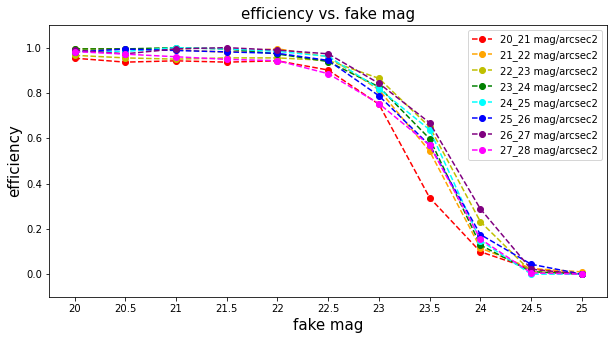

In [9]:
color_list = ['r', 'orange', 'y', 'g', 'cyan', 'b', 'purple', 'magenta']


fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for host_idx, host_mag in enumerate(host_mag_list):
    color = color_list[host_idx]
    ax.plot(fake_mag_list, eff_dict[host_mag], marker='o', ls='--', color=color, label=host_mag + ' mag/arcsec2')
    ax.set_xticks(fake_mag_list)
    ax.set_xticklabels(fake_mag_list)
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlabel('fake mag', size=15)
    ax.set_ylabel('efficiency', size=15)
    ax.set_title('efficiency vs. fake mag', size=15)
    ax.legend()


In [14]:
import warnings
warnings.filterwarnings('ignore')

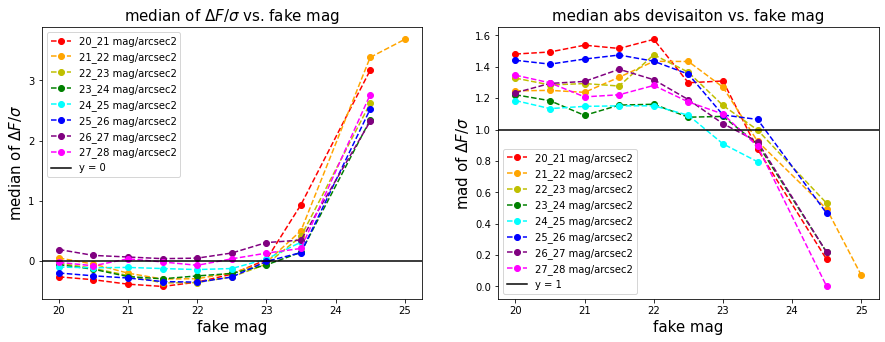

In [25]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
for host_idx, host_mag in enumerate(host_mag_list):
    color = color_list[host_idx]
    median_list = []
    std_list = []
    for fake_idx, fake_mag in enumerate([20, 20.5, 21, 21.5, 22, 22.5, 23, 23.5, 24.5, 25]):
        fake_mag_str = str(fake_mag).replace('.', '')

        fake_src = fake_src_df.loc[
            np.logical_and(
                fake_src_df.host_mag == host_mag, fake_src_df.fake_mag == fake_mag_str
        )]
        detected_fake = fake_src.loc[fake_src.matched_status.astype(bool)]
        
        detected_fake = detected_fake.loc[
            np.abs(detected_fake.base_PsfFlux_instFlux / detected_fake.base_PsfFlux_instFluxErr) > threshold
        ]
        df = (detected_fake.base_PsfFlux_instFlux - detected_fake.injected_instFlux) / detected_fake.base_PsfFlux_instFluxErr
        
        clipped, _, _ = stats.sigmaclip(df)
        median = np.nanmedian(clipped)
        std = median_abs_deviation(clipped, scale='normal', nan_policy='omit')
        median_list.append(median)
        std_list.append(std)
    ax[0].plot([20, 20.5, 21, 21.5, 22, 22.5, 23, 23.5, 24.5, 25], median_list, 'o--', color=color, label=host_mag + ' mag/arcsec2')
    ax[1].plot([20, 20.5, 21, 21.5, 22, 22.5, 23, 23.5, 24.5, 25], std_list, 'o--', color=color, label=host_mag + ' mag/arcsec2')
    
ax[0].axhline(y=0, color='k', label='y = 0 ')
ax[0].set_title(r'median of $\Delta F/\sigma$ vs. fake mag', size=15)
ax[0].set_xlabel('fake mag', size=15)
ax[0].set_ylabel(r'median of $\Delta F/\sigma$', size=15)
ax[0].legend()
ax[1].axhline(y=1,color='k', label='y = 1')
ax[1].set_title(r'median abs devisaiton vs. fake mag', size=15)
ax[1].set_xlabel('fake mag', size=15)
ax[1].set_ylabel(r'mad of $\Delta F/\sigma$', size=15)
ax[1].legend()

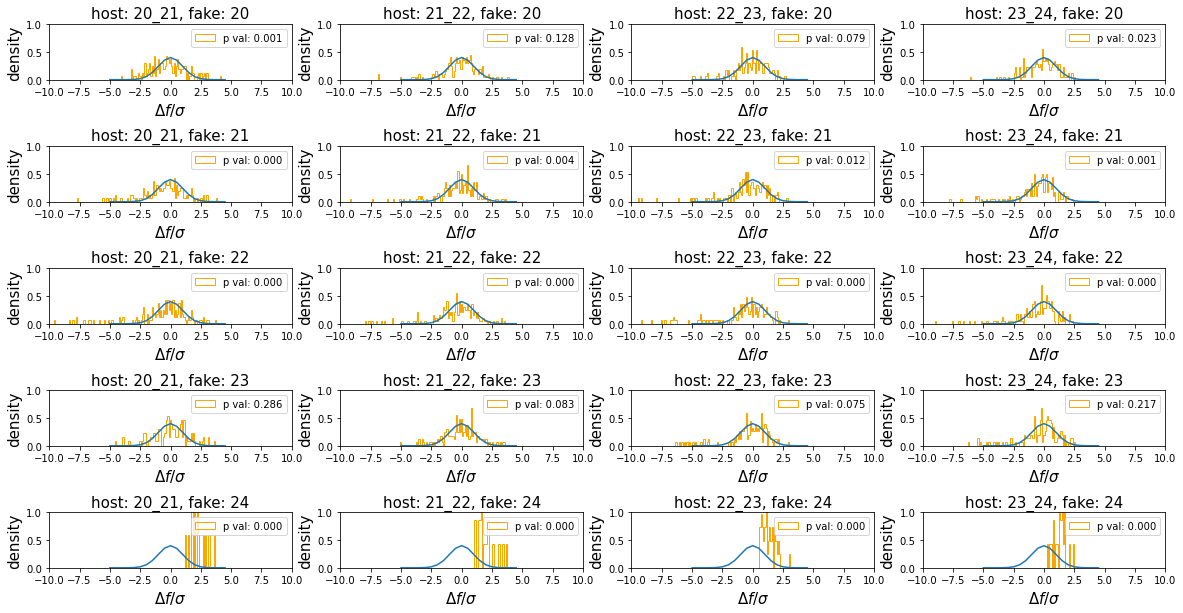

In [26]:
norm_x = np.arange(-5, 5, 0.5)
norm_y = norm.pdf(norm_x)
norm_cdf = stats.norm(loc=0, scale=1).cdf
threshold = 5
bins = np.linspace(-10, 10, 200)


fig, ax = plt.subplots(5, 4, figsize=(20, 10))
fig.subplots_adjust(hspace=1.2)

for host_idx, host_mag in enumerate(['20_21', '21_22', '22_23', '23_24']):
    for fake_idx, fake_mag in enumerate([20, 21, 22, 23, 24]):
        fake_mag_str = str(fake_mag).replace('.', '')

        fake_src = fake_src_df.loc[
            np.logical_and(
                fake_src_df.host_mag == host_mag, fake_src_df.fake_mag == fake_mag_str
        )]
        detected_fake = fake_src.loc[fake_src.matched_status.astype(bool)]
        
        detected_fake = detected_fake.loc[
            np.abs(detected_fake.base_PsfFlux_instFlux / detected_fake.base_PsfFlux_instFluxErr) > threshold
        ]
        
        
        df = (detected_fake.base_PsfFlux_instFlux - detected_fake.injected_instFlux) / detected_fake.base_PsfFlux_instFluxErr
        clipped, _, _ = stats.sigmaclip(df.to_numpy())
        _, pval = stats.kstest(clipped, norm_cdf)
        
        ax[fake_idx][host_idx].hist(df ,density=True, bins=bins,
                                    color='orange', histtype='step', label=f'p val: {pval:.3f}')
        ax[fake_idx][host_idx].plot(norm_x, norm_y)
        ax[fake_idx][host_idx].set_title(f'host: {host_mag}, fake: {fake_mag}', size=15)
        ax[fake_idx][host_idx].set_xlabel('$\Delta f / \sigma$', size=15)
        ax[fake_idx][host_idx].set_ylabel('density', size=15)
        ax[fake_idx][host_idx].set_xlim(-10, 10)
        ax[fake_idx][host_idx].set_ylim(0, 1.)
        ax[fake_idx][host_idx].legend()
    



photometry accuracy is one topic that difference imaging should focus on

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
for host_idx, host_mag in enumerate(host_mag_list):
    color = color_list[host_idx]
    mean_list = []
    std2_list = []
    for fake_idx, fake_mag in enumerate([20, 20.5, 21, 21.5, 22, 22.5, 23, 23.5, 24.5, 25]):
        fake_mag_str = str(fake_mag).replace('.', '')

        fake_src = fake_src_df.loc[
            np.logical_and(
                fake_src_df.host_mag == host_mag, fake_src_df.fake_mag == fake_mag_str
        )]
        detected_fake = fake_src.loc[fake_src.matched_status.astype(bool)]
        
        detected_fake = detected_fake.loc[
            np.abs(detected_fake.base_PsfFlux_instFlux / detected_fake.base_PsfFlux_instFluxErr) > threshold
        ]
        residual = (detected_fake.base_PsfFlux_instFlux - detected_fake.injected_instFlux) / detected_fake.injected_instFlux
        
        clipped, _, _ = stats.sigmaclip(residual)
        mean = np.mean(clipped)
        std = np.nanstd(clipped, ddof=1)
        mean_list.append(mean)
        std2_list.append(2*std)
    ax[0].plot([20, 20.5, 21, 21.5, 22, 22.5, 23, 23.5, 24.5, 25], mean_list, 'o--', color=color, label=host_mag + ' mag/arcsec2')
    ax[1].plot([20, 20.5, 21, 21.5, 22, 22.5, 23, 23.5, 24.5, 25], std2_list, 'o--', color=color, label=host_mag + ' mag/arcsec2')
    
ax[0].axhline(y=0, color='k', label='y = 0 ')
ax[0].set_title(r'mean residual VS. fake mag', size=15)
ax[0].set_xlabel('fake mag', size=15)
ax[0].set_ylabel(r'mean residual', size=15)
ax[0].legend()
ax[1].axhline(y=0.05,color='k', label='y = 0.05')
ax[1].set_title(r'2 std of residuals VS. fake mag', size=15)
ax[1].set_xlabel('fake mag', size=15)
ax[1].set_ylabel(r'2 std of residuals', size=15)
ax[1].legend()